# Notebook Initialization

In [144]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
spark

In [145]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load CNN

In [91]:
from tensorflow.keras.models import load_model
cnn_model_suffix = "06"
model_file = models_dir / f"feature_extractor_{cnn_model_suffix}.tf"
model = load_model(str(model_file))

model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

# Load datasets

In [92]:
img_size = config.get_int("tfg.training.img_size")
image_target_size = (img_size, img_size)
seed = config.get_int("tfg.seed")
batch_size = config.get_int("tfg.training.batch_size")

In [93]:
from keras_preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

## Train predictions

In [94]:
train_df = repo.load("train_df")
train_generator = test_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=image_target_size)

Found 331286 validated image filenames belonging to 3 classes.


In [95]:
train_generator.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [96]:
class_to_idx = train_generator.class_indices
idx_to_class = { v: k for k, v in class_to_idx.items() }

In [97]:
NUM_TRAIN_BATCHES = train_generator.n // train_generator.batch_size + 1

In [98]:
raw_train_preds = model.predict(train_generator, steps=NUM_TRAIN_BATCHES, verbose=1)
raw_train_preds.shape

10353/10353 [==============================] - 2441s 236ms/step


(331286, 3)

In [119]:
train_preds = raw_train_preds.argmax(axis=1)
train_preds[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [102]:
raw_train_preds.shape

(331286, 3)

In [108]:
raw_train_preds_list = raw_train_preds.tolist()
raw_train_preds_list[:5]

[[0.006345381494611502, 0.2938346266746521, 0.6998199820518494],
 [0.003827716689556837, 0.3122704327106476, 0.683901846408844],
 [0.005725017748773098, 0.38320884108543396, 0.6110661625862122],
 [0.00022382025781553239, 0.29181888699531555, 0.7079572677612305],
 [3.348174141137861e-05, 0.18306158483028412, 0.8169049024581909]]

In [110]:
cp_index = train_generator.class_indices["CP"]
cp_probs = list(map(lambda probs: probs[cp_index], raw_train_preds_list))
cp_probs[:5]

[0.006345381494611502,
 0.003827716689556837,
 0.005725017748773098,
 0.00022382025781553239,
 3.348174141137861e-05]

In [111]:
ncp_index = train_generator.class_indices["NCP"]
ncp_probs = list(map(lambda probs: probs[ncp_index], raw_train_preds_list))
ncp_probs[:5]

[0.2938346266746521,
 0.3122704327106476,
 0.38320884108543396,
 0.29181888699531555,
 0.18306158483028412]

In [112]:
normal_index = train_generator.class_indices["Normal"]
normal_probs = list(map(lambda probs: probs[normal_index], raw_train_preds_list))
normal_probs[:5]

[0.6998199820518494,
 0.683901846408844,
 0.6110661625862122,
 0.7079572677612305,
 0.8169049024581909]

In [116]:
train_df["cp_prob"] = cp_probs
train_df["ncp_prob"] = ncp_probs
train_df["normal_prob"] = normal_probs
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num,cp_prob,ncp_prob,normal_prob
0,NCP,NCP/880/2415/0000.jpg,880,2415,312,5,0,0,0.006345,0.293835,0.699820
1,NCP,NCP/880/2415/0001.jpg,880,2415,312,5,1,0,0.003828,0.312270,0.683902
2,NCP,NCP/880/2415/0002.jpg,880,2415,312,5,2,0,0.005725,0.383209,0.611066
3,NCP,NCP/880/2415/0003.jpg,880,2415,312,5,3,0,0.000224,0.291819,0.707957
4,NCP,NCP/880/2415/0004.jpg,880,2415,312,5,4,0,0.000033,0.183062,0.816905


In [123]:
cp_preds = (train_preds == cp_index).astype("int")
cp_preds[:5]

array([0, 0, 0, 0, 0])

In [124]:
ncp_preds = (train_preds == ncp_index).astype("int")
ncp_preds[:5]

array([0, 0, 0, 0, 0])

In [125]:
normal_preds = (train_preds == normal_index).astype("int")
normal_preds[:5]

array([1, 1, 1, 1, 1])

In [126]:
idx_to_class

{0: 'CP', 1: 'NCP', 2: 'Normal'}

In [128]:
list(map(lambda idx: idx_to_class[idx], train_preds.tolist()))

['Normal', 'Normal', 'Normal', 'Normal', 'Normal']

In [129]:
train_df["cp_pred"] = cp_preds
train_df["ncp_pred"] = ncp_preds
train_df["normal_pred"] = normal_preds
train_df["pred"] = list(map(lambda idx: idx_to_class[idx], train_preds.tolist()))
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num,cp_prob,ncp_prob,normal_prob,cp_pred,ncp_pred,normal_pred,pred
0,NCP,NCP/880/2415/0000.jpg,880,2415,312,5,0,0,0.006345,0.293835,0.699820,0,0,1,Normal
1,NCP,NCP/880/2415/0001.jpg,880,2415,312,5,1,0,0.003828,0.312270,0.683902,0,0,1,Normal
2,NCP,NCP/880/2415/0002.jpg,880,2415,312,5,2,0,0.005725,0.383209,0.611066,0,0,1,Normal
3,NCP,NCP/880/2415/0003.jpg,880,2415,312,5,3,0,0.000224,0.291819,0.707957,0,0,1,Normal
4,NCP,NCP/880/2415/0004.jpg,880,2415,312,5,4,0,0.000033,0.183062,0.816905,0,0,1,Normal


In [130]:
train_sdf = spark.createDataFrame(train_df)
train_sdf.show(5)

+-----+--------------------+----------+-------+-------+---------+-------+--------+--------------------+-------------------+------------------+-------+--------+-----------+------+
|label|                file|patient_id|scan_id|n_slice|num_clips|seq_num|clip_num|             cp_prob|           ncp_prob|       normal_prob|cp_pred|ncp_pred|normal_pred|  pred|
+-----+--------------------+----------+-------+-------+---------+-------+--------+--------------------+-------------------+------------------+-------+--------+-----------+------+
|  NCP|NCP/880/2415/0000...|       880|   2415|    312|        5|      0|       0|0.006345381494611502| 0.2938346266746521|0.6998199820518494|      0|       0|          1|Normal|
|  NCP|NCP/880/2415/0001...|       880|   2415|    312|        5|      1|       0|0.003827716689556837| 0.3122704327106476| 0.683901846408844|      0|       0|          1|Normal|
|  NCP|NCP/880/2415/0002...|       880|   2415|    312|        5|      2|       0|0.005725017748773098|0.

In [133]:
from pyspark.sql import functions as F
scan_preds = train_sdf\
    .groupBy("patient_id", "scan_id")\
    .agg(
        F.first("label").alias("label"),
        F.first("n_slice").alias("n_slice"),
        F.first("num_clips").alias("num_clips"),
        F.avg("cp_prob").alias("avg_cp_prob"),
        F.stddev("cp_prob").alias("stddev_cp_prob"),
        F.avg("ncp_prob").alias("avg_ncp_prob"),
        F.stddev("ncp_prob").alias("stddev_ncp_prob"),
        F.avg("normal_prob").alias("avg_normal_prob"),
        F.stddev("normal_prob").alias("stddev_normal_prob"),
        F.sum("cp_pred").alias("cp_preds"),
        F.sum("ncp_pred").alias("ncp_preds"),
        F.sum("normal_pred").alias("normal_preds")
    )

scan_preds.show(5)

+----------+-------+------+-------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+---------+------------+
|patient_id|scan_id| label|n_slice|num_clips|         avg_cp_prob|      stddev_cp_prob|        avg_ncp_prob|     stddev_ncp_prob|     avg_normal_prob|  stddev_normal_prob|cp_preds|ncp_preds|normal_preds|
+----------+-------+------+-------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+---------+------------+
|       880|   2415|   NCP|    312|        5|0.003093833851277...|0.006690080932743595|  0.4743867077602026| 0.24394925333099726|   0.522519455691322|  0.2452731045575023|       0|      126|         186|
|      1346|   3735|    CP|     53|        1|  0.8482807885925725| 0.16039896432605463|0.019548055759789247|0.013912538753332005|  0.1321711584215628|  0.1684735085438899|      50|    

In [140]:
from pyspark.sql.types import StringType

def get_pred(cp_prob, ncp_prob, normal_prob):
    if cp_prob > ncp_prob and cp_prob > normal_prob:
        return "CP"
    elif ncp_prob > cp_prob and ncp_prob > normal_prob:
        return "NCP"
    elif normal_prob > cp_prob and normal_prob > ncp_prob:
        return "Normal"

get_pred_udf = F.udf(get_pred, StringType())

scan_preds = scan_preds\
    .withColumn("pred", get_pred_udf(F.col("avg_cp_prob"), F.col("avg_ncp_prob"), F.col("avg_normal_prob")))

In [141]:
scan_preds\
    .withColumn("pred", get_pred_udf(F.col("avg_cp_prob"), F.col("avg_ncp_prob"), F.col("avg_normal_prob")))\
    .select("pred", "label", "avg_cp_prob", "avg_ncp_prob", "avg_normal_prob", "stddev_cp_prob", "stddev_ncp_prob", "stddev_normal_prob")\
    .show()

+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  pred| label|         avg_cp_prob|        avg_ncp_prob|     avg_normal_prob|      stddev_cp_prob|     stddev_ncp_prob|  stddev_normal_prob|
+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Normal|   NCP|0.003093833851277...|  0.4743867077602026|   0.522519455691322|0.006690080932743595| 0.24394925333099726|  0.2452731045575023|
|    CP|    CP|  0.8482807885925725|0.019548055759789247|  0.1321711584215628| 0.16039896432605463|0.013912538753332005|  0.1684735085438899|
|    CP|    CP|  0.8816007982600819|0.011515017438903834| 0.10688418793253204| 0.18560722127863982|  0.0196978338976846|  0.1720219199028908|
|   NCP|    CP| 0.47629026724614143|  0.5132465026029174|0.010463224225735444|  0.3424021899168062|  0.3480435206994873|0.012078799903691725|
|   NC

In [149]:
scan_preds_df = scan_preds.toPandas()
scan_preds_df.head(5)

,patient_id,scan_id,label,n_slice,num_clips,avg_cp_prob,stddev_cp_prob,avg_ncp_prob,stddev_ncp_prob,avg_normal_prob,stddev_normal_prob,cp_preds,ncp_preds,normal_preds,pred
0,880,2415,NCP,312,5,0.003094,0.006690,0.474387,0.243949,0.522519,0.245273,0,126,186,Normal
1,1346,3735,CP,53,1,0.848281,0.160399,0.019548,0.013913,0.132171,0.168474,50,0,3,CP
2,1373,3800,CP,55,1,0.881601,0.185607,0.011515,0.019698,0.106884,0.172022,54,0,1,CP
3,1413,3890,CP,66,1,0.476290,0.342402,0.513247,0.348044,0.010463,0.012079,32,34,0,NCP
4,1819,274,Normal,91,2,0.010119,0.043209,0.533136,0.285336,0.456746,0.288921,0,43,48,NCP


In [150]:
repo.save("train_preds_vote", scan_preds_df)

True

## Validation

In [154]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType


def create_vote_predictions(df, datagen, config, img_base_dir, spark):
    img_size = config.get_int("tfg.training.img_size")
    image_target_size = (img_size, img_size)
    seed = config.get_int("tfg.seed")
    batch_size = config.get_int("tfg.training.batch_size")
    
    df_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=str(img_base_dir),
        x_col="file",
        y_col="label",
        batch_size=batch_size,
        seed=seed,
        shuffle=False,
        class_mode="categorical",
        target_size=image_target_size)
    
    class_to_idx = df_generator.class_indices
    idx_to_class = { v: k for k, v in class_to_idx.items() }
    
    NUM_BATCHES = df_generator.n // df_generator.batch_size + 1
    
    raw_preds = model.predict(df_generator, steps=NUM_BATCHES, verbose=1)
    preds = raw_preds.argmax(axis=1)
    raw_preds_list = raw_preds.tolist()
    
    cp_index = class_to_idx["CP"]
    ncp_index = class_to_idx["NCP"]
    normal_index = class_to_idx["Normal"]
    
    cp_probs = list(map(lambda probs: probs[cp_index], raw_preds_list))
    ncp_probs = list(map(lambda probs: probs[ncp_index], raw_preds_list))
    normal_probs = list(map(lambda probs: probs[normal_index], raw_preds_list))
    
    cp_preds = (preds == cp_index).astype("int")
    ncp_preds = (preds == ncp_index).astype("int")
    normal_preds = (preds == normal_index).astype("int")
    
    df["cp_prob"] = cp_probs
    df["ncp_prob"] = ncp_probs
    df["normal_prob"] = normal_probs
    df["cp_pred"] = cp_preds
    df["ncp_pred"] = ncp_preds
    df["normal_pred"] = normal_preds
    df["pred"] = list(map(lambda idx: idx_to_class[idx], preds.tolist()))
    
    sdf = spark.createDataFrame(df)
    scan_preds = sdf\
        .groupBy("patient_id", "scan_id")\
        .agg(
            F.first("label").alias("label"),
            F.first("n_slice").alias("n_slice"),
            F.first("num_clips").alias("num_clips"),
            F.avg("cp_prob").alias("avg_cp_prob"),
            F.stddev("cp_prob").alias("stddev_cp_prob"),
            F.avg("ncp_prob").alias("avg_ncp_prob"),
            F.stddev("ncp_prob").alias("stddev_ncp_prob"),
            F.avg("normal_prob").alias("avg_normal_prob"),
            F.stddev("normal_prob").alias("stddev_normal_prob"),
            F.sum("cp_pred").alias("cp_preds"),
            F.sum("ncp_pred").alias("ncp_preds"),
            F.sum("normal_pred").alias("normal_preds")
        )


    def _get_pred(cp_prob, ncp_prob, normal_prob):
        if cp_prob > ncp_prob and cp_prob > normal_prob:
            return "CP"
        elif ncp_prob > cp_prob and ncp_prob > normal_prob:
            return "NCP"
        elif normal_prob > cp_prob and normal_prob > ncp_prob:
            return "Normal"

    get_pred_udf = F.udf(_get_pred, StringType())

    scan_preds = scan_preds\
        .withColumn(
            "pred",
            get_pred_udf(F.col("avg_cp_prob"), F.col("avg_ncp_prob"), F.col("avg_normal_prob"))
        )
    scan_preds_df = scan_preds.toPandas()
    
    return scan_preds_df

In [155]:
val_df = repo.load("val_df")
val_scan_preds = create_vote_predictions(val_df, test_datagen, config=config, img_base_dir=images_input_dir, spark=spark)
val_scan_preds.head(5)

Found 39828 validated image filenames belonging to 3 classes.
1245/1245 [==============================] - 118s 95ms/step


,patient_id,scan_id,label,n_slice,num_clips,avg_cp_prob,stddev_cp_prob,avg_ncp_prob,stddev_ncp_prob,avg_normal_prob,stddev_normal_prob,cp_preds,ncp_preds,normal_preds,pred
0,450,2055,NCP,34,450,0.068885,0.102521,0.850380,0.231608,0.080735,0.217883,0,31,3,NCP
1,566,2290,NCP,160,566,0.200244,0.316166,0.636572,0.369391,0.163184,0.268835,31,102,27,NCP
2,602,2964,CP,84,602,0.831133,0.187537,0.061089,0.109699,0.107778,0.122036,79,4,1,CP
3,1737,1040,Normal,80,1737,0.057877,0.128790,0.005911,0.014034,0.936212,0.128980,3,0,77,Normal
4,3705,5532,NCP,63,3705,0.454390,0.346227,0.448885,0.405858,0.096725,0.144174,28,31,4,CP


In [156]:
repo.save("val_preds_vote", val_scan_preds)

True

In [157]:
test_df = repo.load("test_df")
test_scan_preds = create_vote_predictions(test_df, test_datagen, config=config, img_base_dir=images_input_dir, spark=spark)
test_scan_preds.head(5)

Found 40415 validated image filenames belonging to 3 classes.
1263/1263 [==============================] - 292s 231ms/step


,patient_id,scan_id,label,n_slice,num_clips,avg_cp_prob,stddev_cp_prob,avg_ncp_prob,stddev_ncp_prob,avg_normal_prob,stddev_normal_prob,cp_preds,ncp_preds,normal_preds,pred
0,86,1305,NCP,117,86,0.030664,0.077382,0.968109,0.079124,0.001227,0.003326,0,117,0,NCP
1,171,1486,NCP,143,171,0.117776,0.236235,0.807134,0.295087,0.075090,0.123907,17,121,5,NCP
2,1713,980,Normal,71,1713,0.598822,0.209418,0.009842,0.013433,0.391336,0.208539,42,0,29,CP
3,2206,661,Normal,77,2206,0.005455,0.010648,0.432917,0.185457,0.561629,0.187593,0,19,58,Normal
4,2758,3289,CP,35,2758,0.597576,0.285313,0.006985,0.025373,0.395439,0.290987,18,0,17,CP


In [158]:
repo.save("test_preds_vote", test_scan_preds)

True

# Evaluation of the different sets

In [175]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

In [164]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [184]:
def print_metrics(dataset, true_labels, pred_labels):
    prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    print(f"{dataset} F1 Score: {100 * f1: .2f}%")
    print(f"{dataset} Precision: {100 * prec: .2f}%")
    print(f"{dataset} Recall: {100 * rec: .2f}%")

In [166]:
class_to_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_to_idx.items() }
class_labels = [k for k in class_to_idx.keys()]

## Training

Normalized confusion matrix
[[0.90317331 0.06102522 0.03580146]
 [0.03091945 0.92188771 0.04719284]
 [0.09865471 0.12892377 0.77242152]]


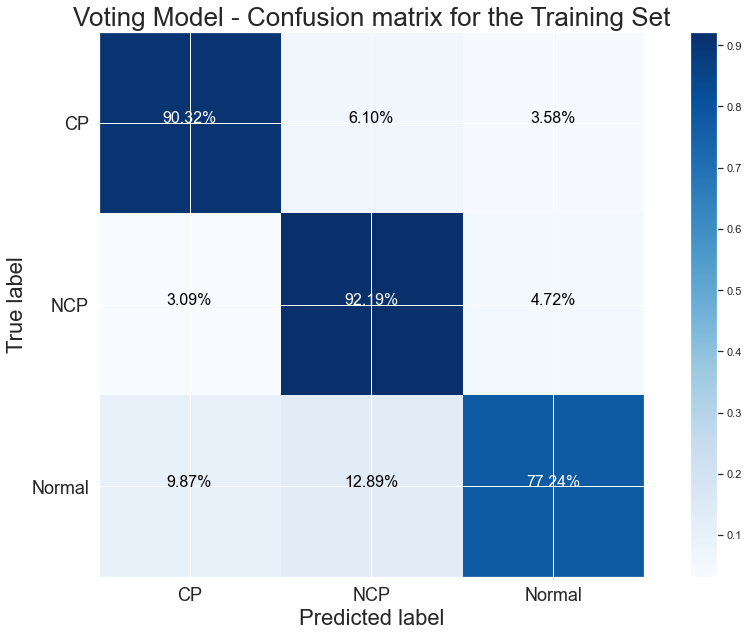

In [180]:
train_preds_df = repo.load("train_preds_vote")
train_preds_df["label_idx"] = train_preds_df["label"].apply(class_to_idx.get)
train_preds_df["pred_idx"] = train_preds_df["pred"].apply(class_to_idx.get)
train_true = train_preds_df["label_idx"].values
train_pred = train_preds_df["pred_idx"].values
train_cm = confusion_matrix(train_true, train_pred)

plot_confusion_matrix(
    train_cm,
    classes=class_labels,
    title='Voting Model - Confusion matrix for the Training Set',
    save_to=figures_dir / "models" / "voting" / f"train_conf_matrix.png")

In [185]:
print_metrics("Training", train_true, train_pred)

Training F1 Score:  87.42%
Training Precision:  87.56%
Training Recall:  87.52%


## Validation

Normalized confusion matrix
[[0.90131579 0.06578947 0.03289474]
 [0.03164557 0.96202532 0.00632911]
 [0.11956522 0.09782609 0.7826087 ]]


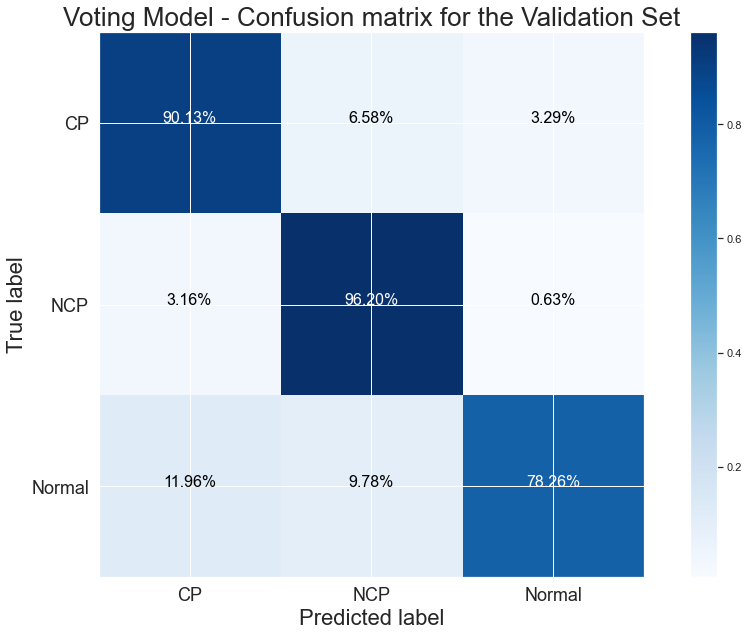

In [179]:
val_preds_df = repo.load("val_preds_vote")
val_preds_df["label_idx"] = val_preds_df["label"].apply(class_to_idx.get)
val_preds_df["pred_idx"] = val_preds_df["pred"].apply(class_to_idx.get)
val_true = val_preds_df["label_idx"].values
val_pred = val_preds_df["pred_idx"].values
val_cm = confusion_matrix(val_true, val_pred)

plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Voting Model - Confusion matrix for the Validation Set',
    save_to=figures_dir / "models" / "voting" / f"val_conf_matrix.png")

In [186]:
print_metrics("Validation", val_true, val_pred)

Validation F1 Score:  89.67%
Validation Precision:  89.92%
Validation Recall:  89.80%


## Test

Normalized confusion matrix
[[0.87428571 0.07428571 0.05142857]
 [0.03184713 0.9044586  0.06369427]
 [0.08510638 0.14893617 0.76595745]]


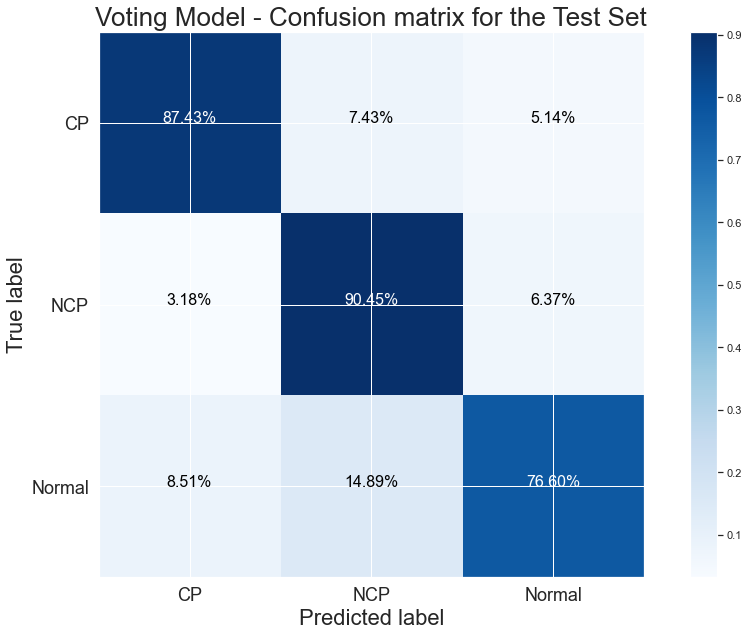

In [181]:
test_preds_df = repo.load("test_preds_vote")
test_preds_df["label_idx"] = test_preds_df["label"].apply(class_to_idx.get)
test_preds_df["pred_idx"] = test_preds_df["pred"].apply(class_to_idx.get)
test_true = test_preds_df["label_idx"].values
test_pred = test_preds_df["pred_idx"].values
test_cm = confusion_matrix(test_true, test_pred)

plot_confusion_matrix(
    test_cm,
    classes=class_labels,
    title='Voting Model - Confusion matrix for the Test Set',
    save_to=figures_dir / "models" / "voting" / f"test_conf_matrix.png")

In [187]:
print_metrics("Test", test_true, test_pred)

Test F1 Score:  86.15%
Test Precision:  86.29%
Test Recall:  86.15%
